In [1]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter
import pandas as pd
import csv
import os.path
import scipy
from scipy.optimize import minimize

In [2]:
# Make an instance for the protein
sequence = [1,1,1,0,0,1] #HPPH
L1 = 3
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  4.2  0.   0.   3.   2.4  0.   0.   0.   0.   0.   2.4  0.
   0.  -1.  -1.   0. ]
 [ 4.2  0.   4.2  0.   0.   0.   0.   2.4  0.   0.   0.   0.   0.   2.4
   0.  -1.  -1.  -1. ]
 [ 4.2  4.2  0.   3.   0.   0.   0.   0.   2.4  0.   0.   0.   0.   0.
   2.4  0.  -1.  -1. ]
 [ 0.   0.   3.   0.   4.2  4.2  0.   0.   3.   2.4  0.   0.   0.   0.
   0.   2.4  0.   0. ]
 [ 0.   0.   0.   4.2  0.   4.2  0.   0.   0.   0.   2.4  0.   0.   0.
   0.   0.   2.4  0. ]
 [ 3.   0.   0.   4.2  4.2  0.   3.   0.   0.   0.   0.   2.4  0.   0.
   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   3.   0.   4.2  4.2  0.   0.   3.   2.4  0.
   0.  -1.  -1.   0. ]
 [ 0.   2.4  0.   0.   0.   0.   4.2  0.   4.2  0.   0.   0.   0.   2.4
   0.  -1.  -1.  -1. ]
 [ 0.   0.   2.4  3.   0.   0.   4.2  4.2  0.   3.   0.   0.   0.   0.
   2.4  0.  -1.  -1. ]
 [ 0.   0.   0.   2.4  0.   0.   0. 

In [3]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

In [4]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params): # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    
# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

def CVaRsamp(params, alpha=1, n=100):#n=antal samples
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,num_qubits) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-1000)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=np.float64(summa/K)
    
    return expvalue

In [5]:
def cost_execution(params):
    params = np.reshape(params, (2, int(len(params)/2)))

    global iterations

    cost = CVaRsamp(params, alpha=a, n=num_of_samples)

    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))
    
    params_list.append(params)
    cost_list.append(cost)

    iterations += 1
    return cost

In [ ]:
alphas = [0.05, 0.10, 0.25, 1.00]
num_of_samples = 1000 #number of samples from the quantum computer/probability distribution
initial_params = np.array([[0.1],[0.1]], requires_grad = True) #first vector is alphas second is betas, (2,1) for P=1, (2,2) for p=2, (2,3) for p=3...
number_of_tests = 20 #number of times you want to run the tests for each alpha, for statistical analysis this should be high
tolerance = 0.001 #Tolerance for when minimizer is done optimizing


data_library = {}
for a in alphas:
    print('Alpha is now :'+ str(a))
    print("="*100)
    counter = 0
    prob_list_list = []
    cost_list_list = []
    iter_needed_list = []
    
    for j in range(number_of_tests):
        iterations = 0
        params_list = []
        prob_list = []
        cost_list = []
        
        out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 1000}, tol=tolerance)
        out_params = np.reshape(out["x"], (2, len(initial_params[0])))
        print(out["x"])
        print(out["success"])
        probs = get_probs(out_params)
        ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states
        
        for i in range(len(params_list)):
            p = get_probs(params_list[i])
            prob_list.append(float(np.sum(p[ground_states_i])))

        prob_list_list.append(prob_list)
        cost_list_list.append(cost_list)
        iter_needed_list.append(iterations)
        
        counter+=1
        print(str(iterations) + ' iterations needed. CVaR cost ended at: ' + str(cost_list[-1]))
        print('Try ' + str(j+1) + ': Success probability of training: ', np.sum(probs[ground_states_i]))
        print("="*50)
    
    data = {
      "CVaR cost": cost_list_list,
      "Ground state probability": prob_list_list,
      "Iterations needed": iter_needed_list
    }
    
    var_name = "data_for_alpha_%s" % a
    data_library[var_name] = data
    
        

Alpha is now :0.05


/tmp/ipykernel_98723/1534872411.py:23: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 1000}, tol=tolerance)


Cost at Step 0: -18.678
[2.28463301 0.23571591]
True
22 iterations needed. CVaR cost ended at: -21.871999999999993
Try 1: Success probability of training:  6.975095370655648e-06
Cost at Step 0: -18.794
[ 2.1308315  -0.03771549]
True
21 iterations needed. CVaR cost ended at: -20.340000000000007
Try 2: Success probability of training:  7.878495488568579e-06
Cost at Step 0: -18.931999999999995
[1.59532561 0.02796965]
True
23 iterations needed. CVaR cost ended at: -20.522
Try 3: Success probability of training:  9.848948654237347e-06
Cost at Step 0: -18.811999999999998
[1.01790683 1.12858582]
True
26 iterations needed. CVaR cost ended at: -20.518
Try 4: Success probability of training:  1.1276688312036341e-07
Cost at Step 0: -19.342000000000006


In [33]:
#This cell creates csv files containing the data generated in the last cell. The files are saved in the 
#folder: pettson_data_test/. 

for index, alpha_data in enumerate(data_library, start=0):
    
    df=pd.DataFrame(data_library[alpha_data])
    
    sek=''
    for i in sequence: #translates 1001 to HPPH etc
        if i==1: 
            sek+='H'
        else: 
            sek+='P'
            
    #filens titel
    parms=('sekvens: ' + str(sek) + ', gridsize: ' + str(L1)+'X'+str(L2) + ', p: ' + str(len(initial_params[0])) + 
           ', alpha: ' + str(alphas[index]) + ', Optimizer: COBYLA, tol: ' + str(tolerance) + ', initial parameters: '
          + str(initial_params[0]) + ', ' + str(initial_params[1]) + ', samples: ' + str(num_of_samples) + ', number of tests: ' + str(number_of_tests)) 

    #checks if file already exists and if so adds 1 to the end of the file name 8)
    while os.path.isfile('pettson_data_test/'+str(sek)+'/'+ str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv'):
        if parms[-1]!=1:
            parms+=(':1')
        else:
            parms[-1]+=1

    df.to_csv('pettson_data_test/'+str(sek)+'/'
              + str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv', 
              index=False, header = True) #save in the right folder (pettson -> sekvens -> 2X2 )

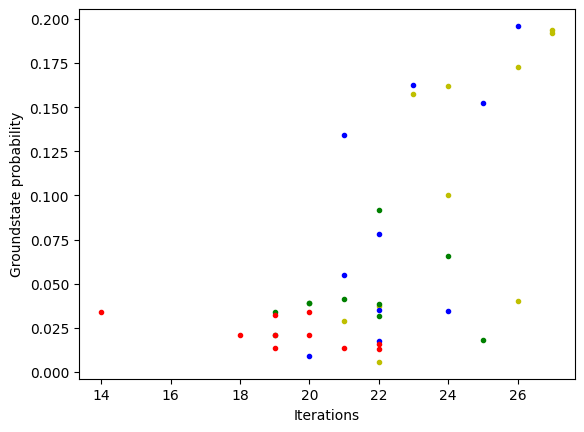

In [9]:
#Både denna och nästa cell ska tas bort så att dataanalysen istället görs i Data_analysis notebooken 

fig, ax = plt.subplots()
for prob_vector in data_library['data_for_alpha_1.0']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'y.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.25']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'b.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.1']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'g.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.05']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'r.', linewidth=0.01)
plt.xlabel('Iterations')
plt.ylabel('Groundstate probability')
plt.show()

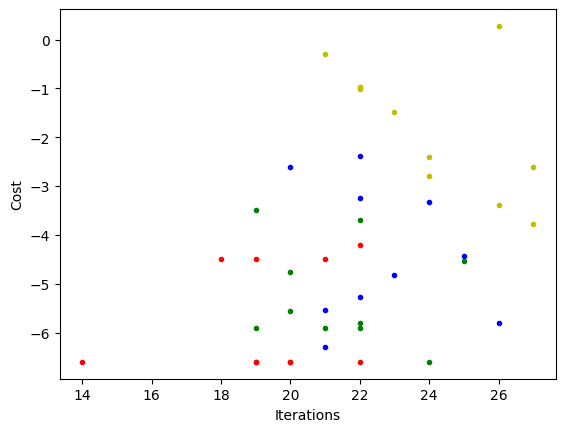

In [10]:
fig, ax = plt.subplots()
for cost_vector in data_library['data_for_alpha_1.0']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'y.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.25']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'b.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.1']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'g.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.05']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'r.', linewidth=1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()